# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

In [3]:
import pandas as pd
import sqlite3

In [4]:
import re

In [5]:
import math

In [6]:
df = pd.read_csv('data/transactions.csv')

In [7]:
df.head()

,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55


Convert dates to `datetime` objects. Two dates have the 32nd of the month as the date, ignore these for now.

In [8]:
df['date'] = [pd.to_datetime(i, errors='ignore') for i in df['date']]

Add currencies column. This works by removing all numeric characters as well as '.' and '-' from the price column leaving only currencies.

In [9]:
def price_to_numeric(price):
    try:
        if price in {'-', 'void', 'nan', 'na'}:
            price = float('nan')
        elif type(price) is str:
            price = float(re.search('[0-9\-]{1,}\.[0-9]{0,}', str(price))[0])
        elif math.isnan(price):
            pass
        return price
    except Exception as E:
        print(f'Failed for {price}')

In [10]:
df['currencies'] = [re.sub('[0-9\.\-]', '', str(i)) for i in df['price']]
df['price'] = [price_to_numeric(price) for price in df['price']]

In [11]:
df.head()

,part,company,country,city,price,date,currencies
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,€
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,2016-01-02 00:05:26,€
2,24385-268,Flipstorm,Greece,Athens,221.73,2016-01-02 00:18:30,€
3,76117-001,Twitterbeat,France,Annecy,1075.82,2016-01-02 02:32:30,€
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,€


## Convert Currency and Fill in Nans
Idea is to make a common euros column and fill NaN values with the average price per part

In [11]:
import requests
import json

KEY = '526e1baa6d7670e0b9028561dcb56949'
endpoint = 'http://data.fixer.io/api/latest?access_key='


REAL_TIME = False
if REAL_TIME:
    page = requests.get(f'{endpoint}{KEY}')
    data = json.loads(page.content)
else:
    page = requests.get('https://gist.githubusercontent.com/zacharyneveu/ebdaa264109edc528e97870f3686b2c0/raw/cf86c535e93f30826d77e64951688e9294304a4a/rates.json')
    data = json.loads(page.content)
rates = data['rates']

data = json.loads(page.content)
rates = data['rates']

rates['GBP']

df['currencies'].value_counts()

cur_abbrevs = {'€': 'EUR', '£': 'GBP', '¥': 'JPY'}

df['cur_abbrevs'] = [cur_abbrevs[sym] if sym in cur_abbrevs.keys() else '' for sym in df['currencies']]

In [12]:
df.head()

,part,company,country,city,price,date,currencies,cur_abbrevs
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,€,EUR
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,2016-01-02 00:05:26,€,EUR
2,24385-268,Flipstorm,Greece,Athens,221.73,2016-01-02 00:18:30,€,EUR
3,76117-001,Twitterbeat,France,Annecy,1075.82,2016-01-02 02:32:30,€,EUR
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,€,EUR


In [13]:
df['price_eur'] = [df['price'][i]/rates[df['cur_abbrevs'][i]] if df['cur_abbrevs'][i] != '' else 0 for i in range(df.shape[0])]

In [14]:
df.head()

,part,company,country,city,price,date,currencies,cur_abbrevs,price_eur
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,€,EUR,784.79
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,2016-01-02 00:05:26,€,EUR,187.99
2,24385-268,Flipstorm,Greece,Athens,221.73,2016-01-02 00:18:30,€,EUR,221.73
3,76117-001,Twitterbeat,France,Annecy,1075.82,2016-01-02 02:32:30,€,EUR,1075.82
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,€,EUR,412.55


In [15]:
import matplotlib.pyplot as plt
%matplotlib widget

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 5.000e+00, 1.500e+01, 1.500e+01, 1.470e+03,
        8.800e+01, 5.540e+02, 1.542e+03, 1.359e+03, 1.151e+03, 1.144e+03,
        9.220e+02, 1.242e+03, 1.334e+03, 8.650e+02, 8.130e+02, 9.010e+02,
        8.980e+02, 1.160e+03, 1.035e+03, 9.310e+02, 8.570e+02, 6.850e+02,
        4.150e+02, 3.070e+02, 1.980e+02, 1.830e+02, 1.150e+02, 9.600e+01,
        6.700e+01, 5.800e+01, 3.500e+01, 3.400e+01, 2.300e+01, 1.500e+01,
        9.000e+00, 8.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00]),
 array([-675.06383131, -618.06775469, -561.07167806, -504.07560144,
        -447.07952481, -390.08344818, -333.08737156, -276.09129493,
        -219.0952183 , -162.09914168, -105.10306505,  -48.10698843,
           8.8890882 ,   65.88516483,  122.88124145,  179.87731808,
         236.87339471,  293.86947133,  350.86554796,  407.86162458,
         464.85770121,  521.85377784

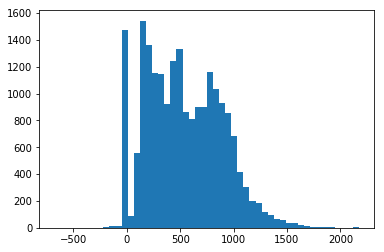

In [16]:
plt.hist(df['price_eur'], 50)

Mean prices in native currency

In [17]:
df[['price', 'cur_abbrevs']].groupby('cur_abbrevs').mean()

,price
cur_abbrevs,
,636.345381
EUR,577.289834
GBP,511.741830
JPY,68650.427735


Mean prices in Euros

In [18]:
df[['price_eur', 'cur_abbrevs']].groupby('cur_abbrevs').mean()

,price_eur
cur_abbrevs,
,0.000000
EUR,577.289834
GBP,574.080033
JPY,583.932966


In [19]:
df.at['company', 0] = "Test"

In [20]:
df.head()

,part,company,country,city,price,date,currencies,cur_abbrevs,price_eur,0
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,€,EUR,784.79,NaN
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,2016-01-02 00:05:26,€,EUR,187.99,NaN
2,24385-268,Flipstorm,Greece,Athens,221.73,2016-01-02 00:18:30,€,EUR,221.73,NaN
3,76117-001,Twitterbeat,France,Annecy,1075.82,2016-01-02 02:32:30,€,EUR,1075.82,NaN
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,€,EUR,412.55,NaN


### TODO: only replace certain companies not whole list

In [21]:
from difflib import get_close_matches

In [22]:
def fix_typos(col, min_thresh):
    """
    col: DataFrame column (Series) of strings to fix typos in
    min_thresh: Minimum count to determine that object is a typo
    """
    counts = col.value_counts()
    rare = [c for c in counts.keys() if counts[c] < min_thresh]
    common = [c for c in counts.keys() if counts[c] >= min_thresh]
    return [c if c in common else (get_close_matches(str(c), common) or [None])[0] for c in col]

In [23]:
for col in ['company', 'country', 'city']:
    df[col] = fix_typos(df[col], 10)

In [24]:
df.head()

,part,company,country,city,price,date,currencies,cur_abbrevs,price_eur,0
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,€,EUR,784.79,NaN
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,2016-01-02 00:05:26,€,EUR,187.99,NaN
2,24385-268,Flipstorm,Greece,Athens,221.73,2016-01-02 00:18:30,€,EUR,221.73,NaN
3,76117-001,Twitterbeat,France,Annecy,1075.82,2016-01-02 02:32:30,€,EUR,1075.82,NaN
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,€,EUR,412.55,NaN


---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

In [25]:
import requests
urlbase = 'https://financialmodelingprep.com/api/v3/'
stock = 'historical-price-full/'
symbols = 'company/stock/list'

In [26]:
def jsonget(url):
    return json.loads(requests.get(url).content)

In [27]:
symbols = jsonget(f'{urlbase}{symbols}')

In [28]:
symbols.keys()

dict_keys(['symbolsList'])

In [29]:
symbols['symbolsList'][0].keys()

dict_keys(['symbol', 'name', 'price'])

In [30]:
names = [a['name'] for a in symbols['symbolsList']]

In [12]:
df['company'][0:20]

0     Chatterbridge
1              Lajo
2         Flipstorm
3       Twitterbeat
4     Chatterbridge
5     Chatterbridge
6             Voomm
7          Buzzbean
8             Zooxo
9              Lajo
10        Flipstorm
11      Brainsphere
12        Flipstorm
13        Flipstorm
14        Flipstorm
15       Thoughtmix
16        Flipstorm
17          Wordify
18      Brainsphere
19    Chatterbridge
Name: company, dtype: object

In [33]:
import random

In [34]:
random.sample(names, 10)

['iPath US Treasury 5-year Bear ETN',
 'Helios and Matheson Analytics Inc',
 'Badger Meter Inc.',
 'Graham Corporation',
 'Roper Technologies Inc.',
 'Triton International Limited',
 'iShares iBonds Dec 2027 Term Corporate',
 'Eaton Vance Floating Rate Income Trust of Beneficial Interest',
 'Vanguard Mortgage-Backed Securities ETF',
 'John Hancock Exchange-Traded Fund Trust Multifactor Developed International']

In [161]:
get_close_matches(df['company'][tter0:10], names)

[]

In [166]:
n for n in names if n.startswith('Fli')]

[]

## Get rich info from dates

In [37]:
from datetime import datetime, timedelta

In [75]:
def get_day_of_quarter(date):
    try:
        quarter = date.quarter
        qstart = datetime(date.year, 3*quarter - 2, 1)
        return int((date-qstart).days)
    except:
        return None

In [76]:
df['day_of_quarter'] = [get_day_of_quarter(i) for i in df['date']]

In [13]:
df.sample(10)

,part,company,country,city,price,date,currencies
11530,49967-724,Zooxo,United Kingdom,London,497.76,2017-08-07 14:40:56,£
11377,43419-018,Wordify,United States,New York,174.50,2017-07-30 18:40:46,$
13681,76314-002,Brainsphere,Portugal,Braga,455.43,2017-12-08 04:10:21,€
17650,10267-2529,Tagtune,Switzerland,Zürich,326.23,2018-07-19 04:37:59,€
3243,0268-6107,Roodel,Portugal,Aranhas,477.12,2016-05-25 19:47:03,€
4927,60505-2867,Zooxo,United Kingdom,London,130.69,2016-08-20 04:31:09,£
3747,37205-992,Twitterbeat,France,Annecy,249.21,2016-06-21 01:41:05,€
16811,52125-444,Eimbee,France,Amiens,285.57,2018-06-04 08:02:03,€
3630,68462-565,Roodel,Portugal,Aranhas,1002.39,2016-06-14 23:31:18,€
17648,17156-617,Twitterbeat,France,Annecy,685.72,2018-07-19 02:52:59,€


In [14]:
df.describe()

,price
count,20557.000000
mean,1175.433147
std,7384.058221
min,-14449.490000
25%,296.390000
50%,536.630000
75%,828.860000
max,199229.640000


---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

---